In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The dataset features **75 different classes of Butterflies**. The dataset contains about **1000+ labelled images** including the validation images. 

Each image belongs to only one butterfly category.

The label of each image are saved in Training_set.csv.

The Testing_set.csv contains names of image in test folder, which you need to predict the label and submit to Data Sprint 107 - Butterfly Image Classification.


In [2]:
from fastai.vision.all import *
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34
import warnings

# Ignore warning messages
warnings.filterwarnings("ignore")

# Import dataset

In [3]:
butterfly_source = Path('/kaggle/input/butterfly-image-classification')
list(butterfly_source.ls())

[Path('/kaggle/input/butterfly-image-classification/Training_set.csv'),
 Path('/kaggle/input/butterfly-image-classification/Testing_set.csv'),
 Path('/kaggle/input/butterfly-image-classification/test'),
 Path('/kaggle/input/butterfly-image-classification/train')]

In [5]:
df_trn = pd.read_csv(butterfly_source/'Training_set.csv')
df_tst = pd.read_csv(butterfly_source/'Testing_set.csv')
df_trn.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [6]:
df_tst.head() # same files in both trn and tst

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


## listing all file names in test folder

In [ ]:
# import os
# import pandas as pd

# # Get the directory path
# directory_path = "/path/to/directory"

# # Get all file names in the directory
# file_names = os.listdir(directory_path)

# # Create a Pandas DataFrame
# df = pd.DataFrame(data={"image_name": file_names})

# # Print the DataFrame
# print(df)

In [7]:
img_path = get_image_files(butterfly_source/'train')
img_path[0]

Path('/kaggle/input/butterfly-image-classification/train/Image_4378.jpg')

In [9]:
im = PILImage.create(img_path[0])
im.shape

(224, 224)

# Build datablock

In [ ]:
# May not use item transformation
# item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.)) 

In [10]:
batch_tfms = [*aug_transforms(size=224, max_warp=0),                
              Normalize.from_stats(*imagenet_stats)]
bs=16

In [11]:
butterfly = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_x = ColReader(['filename'], pref=f'{butterfly_source}/train/'), 
        get_y = ColReader(['label']), 
        splitter = RandomSplitter(),
        batch_tfms = batch_tfms
        ) 

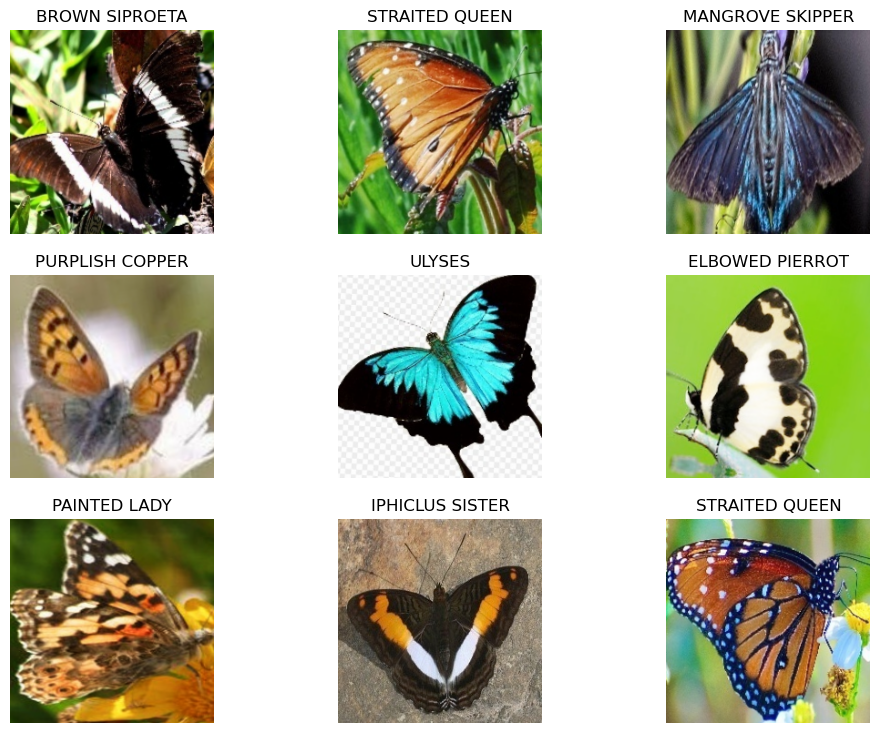

In [13]:
dls = butterfly.dataloaders(df_trn, bs=bs)
dls.show_batch(max_n=9, figsize=(12,9))

In [14]:
dls.vocab

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURPLISH COPPER', 'QUESTION MARK', 'RED ADMIRA

In [15]:
learn = cnn_learner(dls, resnet50, pretrained=True, metrics = accuracy).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.1MB/s]


In [17]:
learn.fit_one_cycle(19)

epoch,train_loss,valid_loss,accuracy,time
0,0.682543,0.488409,0.868360,00:47
1,0.638812,0.420436,0.886836,00:46
2,0.520116,0.391442,0.892995,00:36
3,0.456381,0.382374,0.899923,00:30
4,0.483543,0.382011,0.894534,00:31
5,0.355678,0.398943,0.903772,00:30
6,0.338401,0.377573,0.914550,00:30
7,0.261306,0.360644,0.913010,00:30
8,0.230196,0.338456,0.919938,00:30
9,0.184859,0.326386,0.927637,00:30


In [18]:
learn.save('model.pkl')

Path('models/model.pkl.pth')

# Make batch prediction

In [19]:
test_dl = learn.dls.test_dl(df_tst)
preds = learn.get_preds(dl=test_dl)

In [20]:
class_idxs = preds[0].argmax(dim=1)
res = [dls.vocab[c] for c in class_idxs]
res[:9]

['SOUTHERN DOGFACE',
 'ADONIS',
 'BROWN SIPROETA',
 'MONARCH',
 'GREEN CELLED CATTLEHEART',
 'CAIRNS BIRDWING',
 'GREEN CELLED CATTLEHEART',
 'EASTERN DAPPLE WHITE',
 'BROWN SIPROETA']

In [22]:
df_submit = pd.DataFrame({
    'filename': df_tst['filename'],
    'label': res
})
df_submit.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [24]:
df_submit.to_csv('butterfly_results.csv', index=False)